<a href="https://colab.research.google.com/github/BSMITSME/BookSearchApp/blob/master/CCTV_HELP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
from imutils import paths

In [ ]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


이미지 나누기_train용 / test용

In [ ]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('/content/drive/MyDrive/data_for_cctv/labeled')))
print(len(os.listdir('/content/drive/MyDrive/data_for_cctv/images')))

# !mkdir /content/drive/MyDrive/data_for_cctv/test_images
# !mkdir /content/drive/MyDrive/data_for_cctv/test_annotations


# random.seed(1234)
# idx = random.sample(range(51), 20)

# for img in np.array(sorted(os.listdir('/content/drive/MyDrive/data_for_cctv/images')))[idx]:
#     shutil.move('/content/drive/MyDrive/data_for_cctv/images/'+img, '/content/drive/MyDrive/data_for_cctv/test_images'+img)

# for annot in np.array(sorted(os.listdir('/content/drive/MyDrive/data_for_cctv/labeled')))[idx]:
#     shutil.move('/content/drive/MyDrive/data_for_cctv/labeled/'+annot, '/content/drive/MyDrive/data_for_cctv/test_annotations'+annot)

print(len(os.listdir('/content/drive/MyDrive/data_for_cctv/labeled')))
print(len(os.listdir('/content/drive/MyDrive/data_for_cctv/images')))
print(len(os.listdir('/content/drive/MyDrive/data_for_cctv/test_annotations')))
print(len(os.listdir('/content/drive/MyDrive/data_for_cctv/test_images')))

30
30
30
30
20
20


In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
from bs4 import BeautifulSoup

def generate_box(obj) : 
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj) : 
    if obj.find('name').text == 'help':
        return 1
    elif obj.find('name').text == 'hand' : 
        return 2
    elif obj.find('name').text == 'face' : 
        return 3

    return 0

def generate_target(file) : 
    with open(file) as f : 
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")

        #Beautifulsoup를 활용하여 xml파일의 object 검출
        objects = soup.find_all('object')

        #object들의 개수
        num_objs = len(objects) 

        boxes = []
        labels = []
        boxes.stack()
        labels.stack()
        for i in objects : 
            boxes.append(generate_box(i))
            labels.append(generate_label(i)) 

        #torch로 바꾸어줌 -> 추후 딥러닝 모델 학습을 위한 tensor간의 연산을 준비하기 위해
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64) 

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels

        return target
    
    # jpeg파일인 img 와 xml파일인 annotation을 매개변수로
def plot_image_from_output(img, annotation) : 

    # PyTorch에서는 이미지를 [channels, height, width]로 표현하는 반면
    # matplotlib에서는 [height, width, channels]로 표현하기 때문에
    # permute함수를 통해 순서를 바꾸어 준다.
    # permute(순서)
    img = img.cpu().permute(1,2,0)
    

    # fig, ax = plot_image_from_output
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation['boxes'])) : 
        xmin, ymin, xmax, ymax = annotation['boxes'][idx]

        if annotation['labels'][idx] == 1 : 
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
            
        elif annotation['labels'][idx] == 2 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        elif annotation['labels'][idx] == 3 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')

        else :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
# glob 많은 파일들을 다뤄야 하는 파이썬 프로그램을 작성할 때, 특정한 패턴이나 확장자를 가진 파일들의 
#
img_list = sorted(glob.glob('/content/drive/MyDrive/data_for_cctv/images/*'))
annot_list = sorted(glob.glob('/content/drive/MyDrive/data_for_cctv/labeled/*'))

In [ ]:
print(img_list[:10])
print(annot_list[:10])

['/content/drive/MyDrive/data_for_cctv/images/KakaoTalk_Image_2023-04-06-17-05-44_004.jpeg', '/content/drive/MyDrive/data_for_cctv/images/KakaoTalk_Image_2023-04-06-17-05-44_005.jpeg', '/content/drive/MyDrive/data_for_cctv/images/KakaoTalk_Image_2023-04-06-17-05-45_009.jpeg', '/content/drive/MyDrive/data_for_cctv/images/KakaoTalk_Image_2023-04-06-17-05-45_011.jpeg', '/content/drive/MyDrive/data_for_cctv/images/KakaoTalk_Image_2023-04-06-17-05-45_012.jpeg', '/content/drive/MyDrive/data_for_cctv/images/KakaoTalk_Image_2023-04-06-17-05-45_013.jpeg', '/content/drive/MyDrive/data_for_cctv/images/KakaoTalk_Image_2023-04-06-17-05-46_014.jpeg', '/content/drive/MyDrive/data_for_cctv/images/KakaoTalk_Image_2023-04-06-17-05-46_015.jpeg', '/content/drive/MyDrive/data_for_cctv/images/KakaoTalk_Image_2023-04-06-17-05-46_017.jpeg', '/content/drive/MyDrive/data_for_cctv/images/KakaoTalk_Image_2023-04-06-17-05-46_018.jpeg']
['/content/drive/MyDrive/data_for_cctv/labeled/KakaoTalk_Image_2023-04-06-17-05

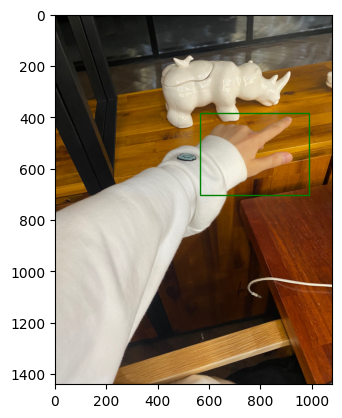

In [ ]:
img_list.index('/content/drive/MyDrive/data_for_cctv/images/KakaoTalk_Image_2023-04-06-17-05-44_004.jpeg')

bbox = generate_target(annot_list[1])
plot_image_from_output(img_list[1], bbox)

In [ ]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-4] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("/content/drive/MyDrive/data_for_cctv/test_annotations/", file_label)
        else:
            label_path = os.path.join("/content/drive/MyDrive/data_for_cctv/labeled/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
        #TypeError: target labels must of int64 type, instead got torch.float32
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, '/content/drive/MyDrive/data_for_cctv/images/')
test_dataset = MaskDataset(data_transform, '/content/drive/MyDrive/data_for_cctv/test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [ ]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
torch.cuda.is_available()

True

In [ ]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------
epoch : 1, Loss : 9.81987476348877, time : 39.822028398513794
epoch : 2, Loss : 8.136178016662598, time : 7.823097229003906
epoch : 3, Loss : 7.637948989868164, time : 7.901893138885498
epoch : 4, Loss : 6.958395481109619, time : 7.904517889022827
epoch : 5, Loss : 6.730193614959717, time : 7.889776229858398
epoch : 6, Loss : 6.395156383514404, time : 7.813070774078369
epoch : 7, Loss : 7.055359363555908, time : 7.745786428451538
epoch : 8, Loss : 6.470616340637207, time : 7.737018346786499
epoch : 9, Loss : 5.651488304138184, time : 7.698432207107544
epoch : 10, Loss : 4.3738532066345215, time : 7.739984035491943


In [ ]:
# 예측
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([[379.7530, 295.7120, 790.5331, 697.2453]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9737], device='cuda:0')}, {'boxes': tensor([[439.0930, 206.1579, 836.1188, 665.6559]], device='cuda:0'), 'labels': tensor([2], device='cuda:0'), 'scores': tensor([0.9610], device='cuda:0')}]


Target :  tensor([2])


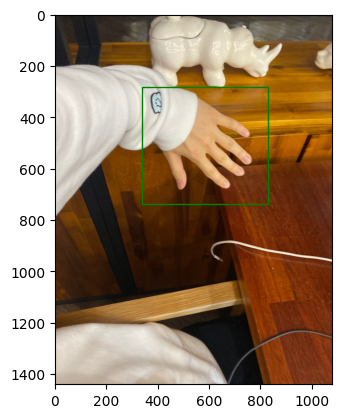

Prediction :  tensor([2], device='cuda:0')


TypeError: ignored

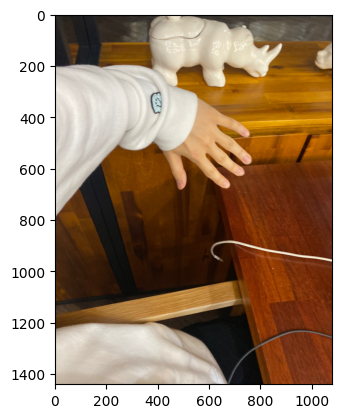

In [ ]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])